In [ ]:
!pip install transformers
!pip install df2gspread
!pip install prometheus-api-client
!pip install oauth2client
!pip install torch
!pip install auth
!pip install --upgrade --quiet gspread

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from psutil import cpu_percent
from matplotlib.animation import FuncAnimation
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from df2gspread import df2gspread as d2g
import df2gspread
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from prometheus_api_client import PrometheusConnect
import random

## Train Data

In [ ]:
training_set_df = pd.read_csv('data.csv')
training_set_= training_set_df.iloc[:,1].values
training_set=np.expand_dims(training_set_, axis=1)
training_set.shape

(22999, 1)

In [ ]:
"""## Dataloading"""

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [ ]:
seq_length = 4
x, y = sliding_windows(training_set, seq_length)

In [ ]:
x.shape,y.shape

((22994, 4, 1), (22994, 1))

In [ ]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))
dataX.shape,dataY.shape

(torch.Size([22994, 4, 1]), torch.Size([22994, 1]))

In [ ]:
trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))
trainX.shape,trainY.shape

(torch.Size([15405, 4, 1]), torch.Size([15405, 1]))

In [ ]:
testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
testX.shape,testY.shape

(torch.Size([7589, 4, 1]), torch.Size([7589, 1]))

## Model

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

In [ ]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm

In [ ]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

In [ ]:
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 112.48013
Epoch: 100, loss: 111.69661
Epoch: 200, loss: 110.99313
Epoch: 300, loss: 110.36404
Epoch: 400, loss: 109.81435
Epoch: 500, loss: 109.30724
Epoch: 600, loss: 109.08120
Epoch: 700, loss: 108.47186
Epoch: 800, loss: 108.11949
Epoch: 900, loss: 107.80260
Epoch: 1000, loss: 107.51493
Epoch: 1100, loss: 107.25146
Epoch: 1200, loss: 107.01277
Epoch: 1300, loss: 106.78038
Epoch: 1400, loss: 106.67872
Epoch: 1500, loss: 106.36123
Epoch: 1600, loss: 106.17095
Epoch: 1700, loss: 105.97476
Epoch: 1800, loss: 105.79173
Epoch: 1900, loss: 105.60867


## Evaluation

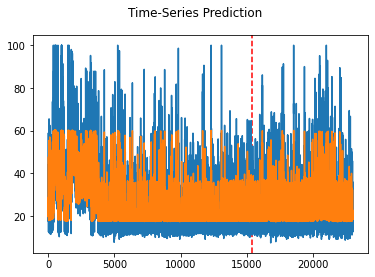

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
torch.save(lstm.state_dict(),"model")

In [ ]:
model = LSTM(num_classes, input_size, hidden_size, num_layers)
model.load_state_dict(torch.load("model"))

<All keys matched successfully>

## Loading saved model

In [ ]:
df=pd.read_csv("data.csv")
n = random. randint(0,len(df)-4)
val=df.iloc[n:n+4,1].values
val=np.expand_dims(val, axis=1)
# print(val.shape)
val=np.expand_dims(val, axis=0)
val_t=Variable(torch.Tensor(val))

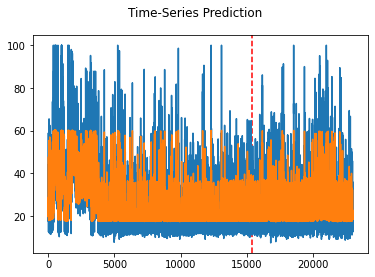

In [ ]:
lstm=model
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()